# Predicting Credit Risk For Loans

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, 
    roc_curve,
    accuracy_score,
    precision_score, 
    recall_score,
    roc_auc_score,
    classification_report
)

In [14]:
df = pd.read_csv("datasets/credit_risk_dataset.csv")

### Light EDA

In [15]:
df.sample(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
31901,40,33600,RENT,8.0,EDUCATION,E,19275,14.50,1,0.57,N,11
109,25,12816,OWN,0.0,DEBTCONSOLIDATION,C,3000,12.87,1,0.23,Y,4
5155,24,44000,OWN,8.0,VENTURE,A,14500,7.29,0,0.33,N,2
1152,23,85500,RENT,1.0,EDUCATION,C,17000,13.11,0,0.20,Y,2
4276,25,78996,RENT,9.0,EDUCATION,A,4500,8.63,0,0.06,N,2


In [16]:
df.shape

(32581, 12)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [18]:
df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [19]:
df.nunique()

person_age                      58
person_income                 4295
person_home_ownership            4
person_emp_length               36
loan_intent                      6
loan_grade                       7
loan_amnt                      753
loan_int_rate                  348
loan_status                      2
loan_percent_income             77
cb_person_default_on_file        2
cb_person_cred_hist_length      29
dtype: int64

In [20]:
df.isna().mean()

person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
person_emp_length             0.027470
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
loan_int_rate                 0.095639
loan_status                   0.000000
loan_percent_income           0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
dtype: float64

In [21]:
df.duplicated().sum()

165

We will want to drop duplicated rows.

Almost 10% of `loan_int_rate` has missing values. Let's impute everything with the mean later. 

### Preprocessing & Feature Engineering

In [22]:
# Drop duplicate rows
df.drop_duplicates(inplace=True)
df.shape

(32416, 12)

In [23]:
# Fill na values with the respected means
df['person_emp_length'].fillna(df['person_emp_length'].mean(), inplace=True)
df['loan_int_rate'].fillna(df['loan_int_rate'].mean(), inplace=True)
df.shape

(32416, 12)

In [27]:
# Encode categorical variables
df = pd.get_dummies(df, columns=['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'], drop_first=True)
df.sample(5)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
8701,23,60000,6.0,25600,11.017265,0,0.43,4,False,False,...,False,False,False,False,True,False,False,False,False,False
12181,25,80000,9.0,14000,15.620000,0,0.17,4,False,False,...,False,False,True,False,False,True,False,False,False,True
28866,28,80000,13.0,21000,11.360000,0,0.26,10,False,False,...,False,False,False,True,False,False,False,False,False,False
11262,22,48000,7.0,10000,17.990000,1,0.21,4,False,False,...,False,False,False,False,False,False,True,False,False,True
23750,27,65000,2.0,10000,12.530000,0,0.15,7,False,False,...,False,False,False,True,False,False,False,False,False,False


In [33]:
# Scale continuous features
scaler = StandardScaler()
continuous_cols = [col for col in df.columns if df[col].nunique() > 5]
df[continuous_cols] = scaler.fit_transform(df[continuous_cols])
df.sample(5)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
32508,3.974344,0.466154,4.698633,-0.568410,-1.815530,0,-1.032202,5.959324,False,True,...,False,True,False,False,False,False,False,False,False,False
27567,0.197197,0.337152,-0.927157,0.855048,-0.138588,0,-0.002339,0.046490,False,False,...,False,False,False,True,False,False,False,False,False,False
1087,-0.589708,0.099305,0.051241,1.266269,2.002189,1,0.372156,-0.446246,False,False,...,True,False,False,False,False,False,True,False,False,True
5473,-1.061852,-0.340108,0.051241,-0.252086,-1.137617,0,0.091284,-0.446246,False,False,...,False,False,False,False,False,False,False,False,False,False
4425,-0.274946,-0.417122,-1.171757,-0.410248,-1.173297,0,-0.002339,-0.938982,False,False,...,False,True,False,False,False,False,False,False,False,False


### Model Building

In [34]:
# Split the data into features and target
TARGET = 'loan_status'
X = df.drop('loan_status', axis=1)
y = df['loan_status']

In [36]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# Train and evaluate the model
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of True

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'Accuracy: {accuracy*100: .1f}% | Precision:{precision*100: .1f}% | Recall:{recall*100: .1f}% | ROC_AUC: {roc_auc*100: .1f}%')

Accuracy:  86.6% | Precision: 77.3% | Recall: 54.6% | ROC_AUC:  75.1%


### Model Evaluation

In [56]:
# Generate classification report summary
class_report = classification_report(y_test, y_pred, target_names=['No Default', 'Default'])
print(class_report)

              precision    recall  f1-score   support

  No Default       0.88      0.96      0.92      5073
     Default       0.77      0.55      0.64      1411

    accuracy                           0.87      6484
   macro avg       0.83      0.75      0.78      6484
weighted avg       0.86      0.87      0.86      6484



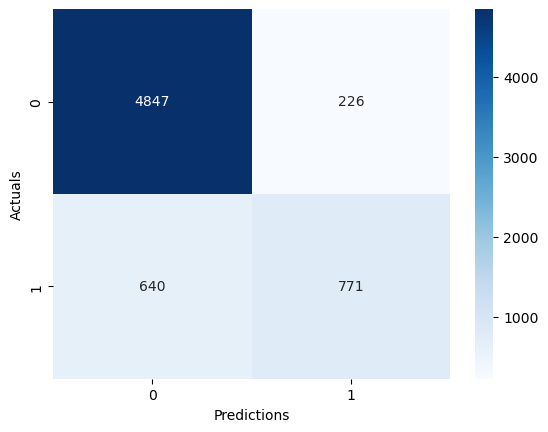

In [67]:
# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g') # 'g' ensures normal integer format
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.show()

In [57]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test , y_pred)

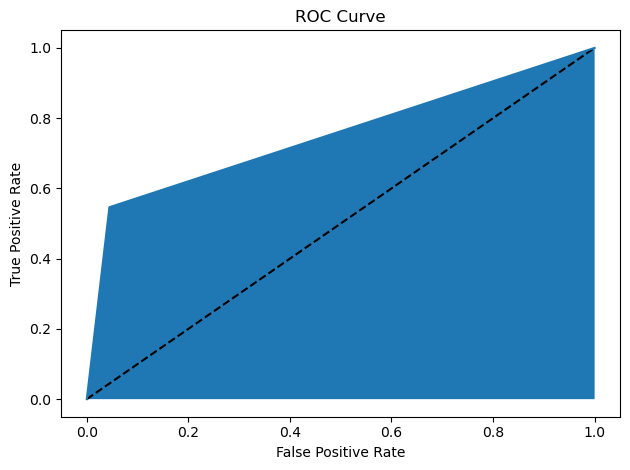

In [64]:
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

plt.fill_between(fpr, tpr)
plt.tight_layout()
plt.show()